# Bet Classifier - Determining how much to bet in Blackjack

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils.classifier_utils import *
from catboost import CatBoostRegressor

In [2]:
#set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


## Load the dataset

In [4]:
dataset_name =  'f_PPO_counting_1_deck_linear_lr_dataset.csv'
dataset = pd.read_csv('data/datasets/' + dataset_name,dtype=np.float32)
print(dataset.head())

   Ace  Two  Three  Four  Five  Six  Seven  Eight  Nine  Ten  Reward
0  1.0  2.0    1.0   2.0   2.0  1.0    1.0    3.0   1.0  6.0    -1.0
1  0.0  1.0    1.0   1.0   1.0  0.0    0.0    0.0   1.0  4.0     0.0
2  1.0  1.0    0.0   1.0   2.0  0.0    0.0    3.0   2.0  8.0    -1.0
3  2.0  2.0    1.0   3.0   0.0  1.0    1.0    3.0   3.0  7.0    -0.5
4  1.0  2.0    2.0   0.0   1.0  1.0    3.0    1.0   1.0  5.0    -0.5


## Prepare dataloader for training

In [5]:
#split dataset into training and validation
batch_size = 1000
dataset_usage = 1.0 #percentage of dataset to use in total
split = 0.8 #percentage of dataset_usafe to use for training
train_dataset = BetsDataset(dataset.iloc[:int(len(dataset)*dataset_usage*split)])
val_dataset = BetsDataset(dataset.iloc[int(len(dataset)*dataset_usage*split):int(len(dataset)*dataset_usage)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [6]:
print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))


Training dataset size: 8000000
Validation dataset size: 2000000


In [7]:
catboost_model = CatBoostRegressor(iterations=300, depth=4, learning_rate=0.1, loss_function='RMSE', task_type='GPU', devices='0:1', verbose=True)
catboost_model.fit(train_dataset.X, train_dataset.y, eval_set=(val_dataset.X, val_dataset.y), verbose=True)



0:	learn: 1.0458491	test: 1.0460290	best: 1.0460290 (0)	total: 107ms	remaining: 32s
1:	learn: 1.0458186	test: 1.0459998	best: 1.0459998 (1)	total: 160ms	remaining: 23.8s
2:	learn: 1.0457935	test: 1.0459762	best: 1.0459762 (2)	total: 213ms	remaining: 21.1s
3:	learn: 1.0457718	test: 1.0459536	best: 1.0459536 (3)	total: 268ms	remaining: 19.8s
4:	learn: 1.0457511	test: 1.0459343	best: 1.0459343 (4)	total: 320ms	remaining: 18.9s
5:	learn: 1.0457340	test: 1.0459167	best: 1.0459167 (5)	total: 372ms	remaining: 18.2s
6:	learn: 1.0457191	test: 1.0459030	best: 1.0459030 (6)	total: 423ms	remaining: 17.7s
7:	learn: 1.0457042	test: 1.0458857	best: 1.0458857 (7)	total: 474ms	remaining: 17.3s
8:	learn: 1.0456910	test: 1.0458739	best: 1.0458739 (8)	total: 526ms	remaining: 17s
9:	learn: 1.0456787	test: 1.0458613	best: 1.0458613 (9)	total: 577ms	remaining: 16.7s
10:	learn: 1.0456683	test: 1.0458498	best: 1.0458498 (10)	total: 630ms	remaining: 16.5s
11:	learn: 1.0456561	test: 1.0458380	best: 1.0458380 (11

In [8]:
predictions = catboost_model.predict(val_dataset.X)


In [9]:
#plot average reward for samples with prediction above threshold

thresholds = np.linspace(0,1,100)
average_rewards = []
average_bet = []
counts = []
dynamic_average_rewards = []
odds = 20.0
for threshold in thresholds:
    mask = predictions > threshold
    p = val_dataset.y[mask]
    #find remaining samples
    not_p = val_dataset.y[~mask]
    if len(p) == 0:
        thresholds = thresholds[:np.where(thresholds == threshold)[0][0]]
        break
    count = len(p)
    counts.append(count)
    average_reward= np.mean(p)
    average_rewards.append(average_reward)
    not_p_average_reward = np.mean(not_p)
    #do a weighted average
    dynamic_reward = (average_reward*odds*count + not_p_average_reward*len(not_p))/(odds*count + len(not_p))
    dynamic_average_rewards.append(dynamic_reward)





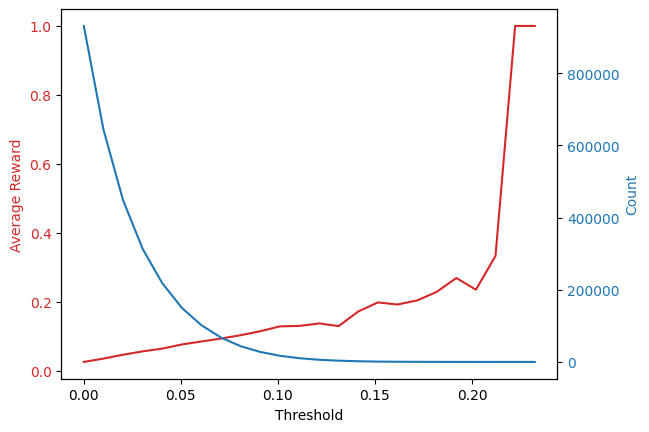

In [10]:

#plot average reward on one axis and count on the other
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Average Reward', color=color)
ax1.plot(thresholds, average_rewards, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Count', color=color)
ax2.plot(thresholds, counts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

Text(0.5, 1.0, 'Dynamic Average Reward vs Threshold')

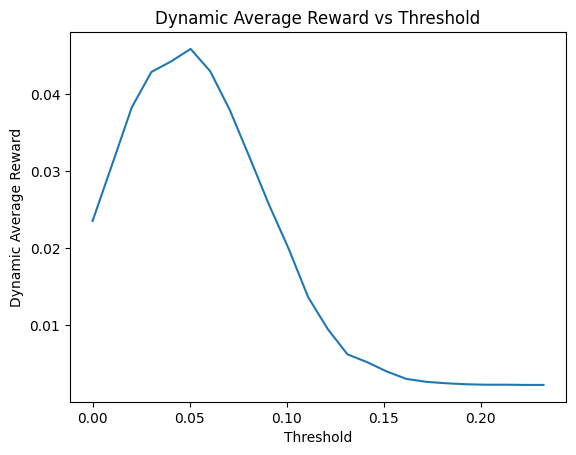

In [11]:
#plot the dynamic betting rewards for each threshold
plt.figure()
plt.plot(thresholds, dynamic_average_rewards)
plt.xlabel('Threshold')
plt.ylabel('Dynamic Average Reward')
plt.title('Dynamic Average Reward vs Threshold')


In [12]:
best_threshold = thresholds[np.argmax(dynamic_average_rewards)]
print(f"Best threshold: {thresholds[np.argmax(dynamic_average_rewards)]}") 
print(f"Best dynamic average reward: {np.max(dynamic_average_rewards)}")
print(f"number of samples with high bets: {counts[np.argmax(dynamic_average_rewards)]}")

Best threshold: 0.05050505050505051
Best dynamic average reward: 0.04585151927704613
number of samples with high bets: 149836


In [13]:
# save model
model_name = dataset_name.replace('dataset.csv', 'catboost_model.cbm')
catboost_model.save_model('data/classifiers/' + model_name)

In [15]:
print(best_threshold)

0.05050505050505051


In [16]:
np.save('data/classifiers/' + model_name.replace('catboost_model.cbm', 'threshold.npy'), best_threshold)